# LSTM预测离散化之后的sin函数

In [1]:
import os 
os.chdir('E:\Jupyterspace')

## 1、手动构造计算图-单层

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.rnn as rnn
import matplotlib.pyplot as plt

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#---------------------------参数设置----------------------------------------------#
# 网络参数
TIME_STEPS=10 # 每10个输入为一个循环，设置一个时间步中折叠的递归步数
BATCH_SIZE=128
HIDDEN_UNITS=1 # 隐层神经元个数
LEARNING_RATE=0.001
EPOCH=150

# 数据参数
TRAIN_EXAMPLES=10000 # 设置训练集例数10000
TEST_EXAMPLES=1000 # 测试集例数

In [4]:
#------------------------------------生成sin数据-----------------------------------#
# np.linspace 生成0-100的等差序列TRAIN_EXAMPLES=10000例
# np.sin 计算上述等差序列对应的sin值作为最终训练数据

# 训练集10000例
seq_train=np.sin(np.linspace(start=0,stop=100,num=TRAIN_EXAMPLES,dtype=np.float32))
# 测试集1000例
seq_test=np.sin(np.linspace(start=100,stop=110,num=TEST_EXAMPLES,dtype=np.float32))

In [5]:
#--------------------- 将一列数据生成x和y，前TIMESTEPS各作为x，TIMESTEPS+1作为y------------------------------+
# 序列的第i项和后面的TIMESTEPS项合在一起作为输入;第i+TIMESTEPS项作为输出
# 即用前面的TIMESTPES个点的信息，预测第i+TIMESTEPS个点的函数值
def generate(seq):
    X=[]
    y=[]
    for i in range(len(seq)-TIME_STEPS):
        X.append([seq[i:i+TIME_STEPS]])
        y.append([seq[i+TIME_STEPS]])
    return np.array(X,dtype=np.float32),np.array(y,dtype=np.float32)

In [6]:
#----------------------------------将sin序列数据生成为输入输出数据--------------------------------#
X_train,y_train=generate(seq_train)
X_test,y_test=generate(seq_test)

#------------------------------- reshape to (batch,time_steps,input_size)--------------------------------#
X_train=np.reshape(X_train,newshape=(-1,TIME_STEPS,1))
X_test=np.reshape(X_test,newshape=(-1,TIME_STEPS,1))


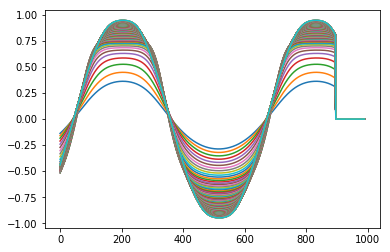

In [7]:
#--------------------------------------Define Graph---------------------------------------------------#
graph=tf.Graph()
with graph.as_default():
    
    #------------------------------------construct LSTM------------------------------------------#

    #place hoder
    X_p=tf.placeholder(dtype=tf.float32,shape=(None,TIME_STEPS,1),name="input_placeholder")
    y_p=tf.placeholder(dtype=tf.float32,shape=(None,1),name="pred_placeholder")
    
    #lstm instance
    lstm_cell=rnn.BasicLSTMCell(num_units=HIDDEN_UNITS)

    #initialize to zero 参数初始化
    init_state=lstm_cell.zero_state(batch_size=BATCH_SIZE,dtype=tf.float32)

    #dynamic rnn
    outputs,states=tf.nn.dynamic_rnn(cell=lstm_cell,inputs=X_p,initial_state=init_state,dtype=tf.float32)
    #print(outputs.shape)
    h=outputs[:,-1,:]
    #print(h.shape)
    #---------------------------------define loss and optimizer----------------------------------#
    mse=tf.losses.mean_squared_error(labels=y_p,predictions=h)
    #print(loss.shape)
    optimizer=tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss=mse)
    init=tf.global_variables_initializer()
#-------------------------------------------Define Session---------------------------------------#
with tf.Session(graph=graph) as sess:
    sess.run(init)
    for epoch in range(1,EPOCH+1):
        results = np.zeros(shape=(TEST_EXAMPLES, 1))
        train_losses=[]
        test_losses=[]
        # print("epoch:",epoch)
        for j in range(TRAIN_EXAMPLES//BATCH_SIZE):
            _,train_loss=sess.run(
                    fetches=(optimizer,mse),
                    feed_dict={
                            X_p:X_train[j*BATCH_SIZE:(j+1)*BATCH_SIZE],
                            y_p:y_train[j*BATCH_SIZE:(j+1)*BATCH_SIZE]
                        }
            )
            train_losses.append(train_loss)
        # print("average training loss:", sum(train_losses) / len(train_losses))


        for j in range(TEST_EXAMPLES//BATCH_SIZE):
            result,test_loss=sess.run(
                    fetches=(h,mse),
                    feed_dict={
                            X_p:X_test[j*BATCH_SIZE:(j+1)*BATCH_SIZE],
                            y_p:y_test[j*BATCH_SIZE:(j+1)*BATCH_SIZE]
                        }
            )
            results[j*BATCH_SIZE:(j+1)*BATCH_SIZE]=result
            test_losses.append(test_loss)
        # print("average test loss:", sum(test_losses) / len(test_losses))
        plt.plot(range(990),results[:990,0])
    plt.show()
    
# 图中红色粗线是真实值,可以看到,在迭代150个epoch之后,我们的结果越来越接近真实值了

## 2、多层LSTM

In [8]:
#---------------------------参数设置----------------------------------------------#
# 网络参数
HIDDEN_UNITS1=30 # 第一层神经元个数
HIDDEN_UNITS=1 # 第二层隐层神经元个数
EPOCH=50 # 从150降低到50


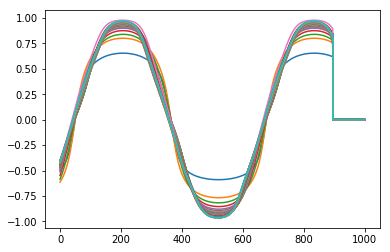

In [9]:
#--------------------------------------Define Graph---------------------------------------------------#
graph=tf.Graph()
with graph.as_default():

    #------------------------------------construct LSTM------------------------------------------#
    #place hoder
    X_p=tf.placeholder(dtype=tf.float32,shape=(None,TIME_STEPS,1),name="input_placeholder")
    y_p=tf.placeholder(dtype=tf.float32,shape=(None,1),name="pred_placeholder")

    #lstm instance
    lstm_cell1=rnn.BasicLSTMCell(num_units=HIDDEN_UNITS1)
    lstm_cell=rnn.BasicLSTMCell(num_units=HIDDEN_UNITS)

    multi_lstm=rnn.MultiRNNCell(cells=[lstm_cell1,lstm_cell])

    #initialize to zero
    init_state=multi_lstm.zero_state(batch_size=BATCH_SIZE,dtype=tf.float32)

    #dynamic rnn
    outputs,states=tf.nn.dynamic_rnn(cell=multi_lstm,inputs=X_p,initial_state=init_state,dtype=tf.float32)
    #print(outputs.shape)
    h=outputs[:,-1,:]
    #print(h.shape)
    #--------------------------------------------------------------------------------------------#

    #---------------------------------define loss and optimizer----------------------------------#
    mse=tf.losses.mean_squared_error(labels=y_p,predictions=h)
    #print(loss.shape)
    optimizer=tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss=mse)


    init=tf.global_variables_initializer()


#-------------------------------------------Define Session---------------------------------------#
with tf.Session(graph=graph) as sess:
    sess.run(init)
    for epoch in range(1,EPOCH+1):
        results = np.zeros(shape=(TEST_EXAMPLES, 1))
        train_losses=[]
        test_losses=[]
        # print("epoch:",epoch)
        for j in range(TRAIN_EXAMPLES//BATCH_SIZE):
            _,train_loss=sess.run(
                    fetches=(optimizer,mse),
                    feed_dict={
                            X_p:X_train[j*BATCH_SIZE:(j+1)*BATCH_SIZE],
                            y_p:y_train[j*BATCH_SIZE:(j+1)*BATCH_SIZE]
                        }
            )
            train_losses.append(train_loss)
       #  print("average training loss:", sum(train_losses) / len(train_losses))


        for j in range(TEST_EXAMPLES//BATCH_SIZE):
            result,test_loss=sess.run(
                    fetches=(h,mse),
                    feed_dict={
                            X_p:X_test[j*BATCH_SIZE:(j+1)*BATCH_SIZE],
                            y_p:y_test[j*BATCH_SIZE:(j+1)*BATCH_SIZE]
                        }
            )
            results[j*BATCH_SIZE:(j+1)*BATCH_SIZE]=result
            test_losses.append(test_loss)
        # print("average test loss:", sum(test_losses) / len(test_losses))
        plt.plot(range(1000),results[:1000,0])
    plt.show()


## 2、使用封装

In [10]:
# 增加一个用于画图的matlab包
import matplotlib as mpl

# TensorFlow的高层封装TFLearn
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat
learn = tf.contrib.learn

In [12]:
# 神经网络参数
HIDDEN_SIZE = 30  # LSTM隐藏节点个数
NUM_LAYERS = 2  # LSTM层数
TIMESTEPS = 10  # 循环神经网络截断长度
BATCH_SIZE = 128  # batch大小

# 数据参数
TRAINING_STEPS = 3000  # 训练轮数
TRAINING_EXAMPLES = 10000  # 训练数据个数
TESTING_EXAMPLES = 1000  # 测试数据个数
SAMPLE_GAP = 0.01  # 采样间隔

In [13]:
# 与之前使用相同训练与测试数据
# 鉴于之前以及修改数据形状，这里对数据进行重置
train_X, train_y = generate(seq_train)
test_X, test_y = generate(seq_test)

Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001C150C1DA20>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'model/'}
Instructions for updating:
Please switch to the Est

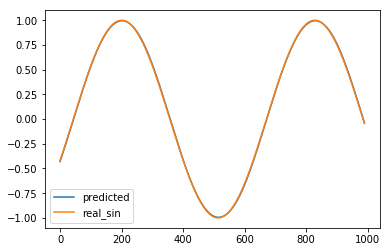

In [14]:

#-------------------------------------以上部分与之前相同--------------------------------------------#

# LSTM结构单元
def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(HIDDEN_SIZE)
    return lstm_cell


def lstm_model(X, y):
    # 使用多层LSTM，不能用lstm_cell*NUM_LAYERS的方法，会导致LSTM的tensor名字都一样
    cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])

    # 将多层LSTM结构连接成RNN网络并计算前向传播结果
    output, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    output = tf.reshape(output, [-1, HIDDEN_SIZE])

    # 通过无激活函数的全联接层计算线性回归，并将数据压缩成一维数组的结构
    predictions = tf.contrib.layers.fully_connected(output, 1, None)

    # 将predictions和labels调整为统一的shape
    y = tf.reshape(y, [-1])
    predictions = tf.reshape(predictions, [-1])

    # 计算损失值
    loss = tf.losses.mean_squared_error(predictions, y)

    # 创建模型优化器并得到优化步骤
    train_op = tf.contrib.layers.optimize_loss(
        loss,
        tf.train.get_global_step(),
        optimizer='Adagrad',
        learning_rate=0.1)

    return predictions, loss, train_op



# 建立深层循环网络模型
regressor = SKCompat(learn.Estimator(model_fn=lstm_model, model_dir='model/'))

# 调用fit函数训练模型
regressor.fit(train_X, train_y, batch_size=BATCH_SIZE, steps=TRAINING_STEPS)

# 使用训练好的模型对测试集进行预测
predicted = [[pred] for pred in regressor.predict(test_X)]

# 计算rmse作为评价指标
rmse = np.sqrt(((predicted - test_y)**2).mean(axis=0))
print('Mean Square Error is: %f' % (rmse[0]))

# 对预测曲线绘图，并存储到sin.jpg
fig = plt.figure()
plot_predicted, = plt.plot(predicted, label='predicted')
plot_test, = plt.plot(test_y, label='real_sin')
plt.legend([plot_predicted, plot_test], ['predicted', 'real_sin'])
plt.show()